In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

In [ ]:
csv = "/media/dan/Data/git/pyspi_testing/prediction/predict_df_4NetMets_20250319.csv"
raw_df = pd.read_csv(csv)

non_predict_columns = ['soz', 'pid', 'time', 'electrode_idx', 'x', 'y', 'z']
predict_columns = [c for c in raw_df.columns if c not in non_predict_columns]

df_modified = raw_df.copy()

# fill nan with median of each column
df_modified[predict_columns] = df_modified[predict_columns].fillna(df_modified[predict_columns].median())

log_features = ['betweenness']
log_columns = []
for x in log_features:
    for col in predict_columns:
        if x in col:
            log_columns.append(col)

# log transform log_columns
# df_modified[log_columns].describe() 
# none of the log_columns have any values less than 0 but they have 0's so +1 to avoid log(0)
df_modified[log_columns] = np.log(df_modified[log_columns] + 1)
cleaned_df = df_modified.copy()

# correlations
print("Calculating correlations...(~4 mins)")
correlations_mat = cleaned_df[predict_columns].corr()



Calculating correlations...(~3 mins)


In [14]:
correlations_upper = correlations_mat.where(np.triu(np.ones(correlations_mat.shape), k=1).astype(bool))

to_include = copy.deepcopy(predict_columns)
to_drop = []

threshold = 0.65
i = 0
prev_len = -np.inf
while len(to_drop) < len(predict_columns):
    # extract pairs where correlation is high
    high_correlations = correlations_upper.loc[to_include,to_include].abs() >= threshold
    # get x/y positions
    xy_positions = np.where(high_correlations)

    pairs = []
    for x,y in zip(xy_positions[0], xy_positions[1]):
        pairs.append((high_correlations.index[x], high_correlations.index[y]))

    counts = {k:0 for k in predict_columns}
    for x in pairs:
        counts[x[0]] += np.abs(correlations_upper.loc[x[0],x[1]])
        counts[x[1]] += np.abs(correlations_upper.loc[x[0],x[1]])

    counts = {k:v for k,v in counts.items() if v >= threshold}
    if len(counts) == 0:
        print(i,'no new drops')
        break
    # sort by counts
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    print(i,counts)
    to_drop.append(counts[0][0])
    to_drop = list(set(to_drop))
    if len(to_drop) == prev_len:
        print(i,'no new drops')
        break
    prev_len = len(to_drop)
    to_include = [x for x in to_include if x not in to_drop]
    # print(len(to_include))
    i += 1

to_drop.extend(['pid', 'time', 'electrode_idx', 'x', 'y', 'z'])

0 [('mi_gaussian~global_efficiency~binary', np.float64(14.726213933712556)), ('pdist_cosine~global_efficiency~binary', np.float64(14.453742095216102)), ('mi_gaussian~characteristic_path_length~binary', np.float64(13.939267607629366)), ('cov_EmpiricalCovariance~characteristic_path_length~weighted', np.float64(11.44368482678303)), ('pdist_cosine~characteristic_path_length~weighted', np.float64(11.323425664145507)), ('cov_EmpiricalCovariance~characteristic_path_length~binary', np.float64(10.997268064558432)), ('cov_EmpiricalCovariance~global_efficiency~binary', np.float64(10.971128055682428)), ('mi_gaussian~density~weighted', np.float64(10.41286144455603)), ('mi_gaussian~density~binary', np.float64(10.41286144455603)), ('pdist_cosine~density~weighted', np.float64(10.346969648073802)), ('pdist_cosine~density~binary', np.float64(10.3469696480738)), ('cohmag_multitaper_mean_fs-1_fmin-0_fmax-0-5~characteristic_path_length~weighted', np.float64(10.262527574349019)), ('cohmag_multitaper_mean_fs

In [15]:
dropped_df = cleaned_df.drop(columns=to_drop).copy()

In [6]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('soz')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('soz')).reshape(-1, 1)
test_labels = np.array(test_df.pop('soz')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [16]:
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [17]:
neg, pos = np.bincount(raw_df['soz'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])


Examples:
    Total: 5568204
    Positive: 695743 (12.49% of total)



In [21]:
output_bias = keras.initializers.Constant(initial_bias)
N_value = train_df.shape[1]
inputs = keras.Input(shape=(N_value,))

# Reshape to (batch, N, 1) to treat each feature as a token.
x = keras.layers.Reshape((N_value, 1))(inputs)

# Self-attention block:
# Using one head with key_dim=1 so that the attention scores have shape (batch, 1, N, N)
attn_layer = keras.layers.MultiHeadAttention(num_heads=1,key_dim=8)
# We set return_attention_scores=True to obtain the attention matrix.
output_tensor, attn_scores = attn_layer(x, x, return_attention_scores=True)
# Remove the head dimension so attn_scores becomes (batch, N, N)
# attn_scores = keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(attn_scores)

# Apply layer normalization to the attention matrix.
x = keras.layers.LayerNormalization()(output_tensor)

# Option 1: Global pooling over the token dimension to reduce (N, N) to a vector of length N.
x = keras.layers.GlobalAveragePooling1D()(x)

# MLP block:
# Dense layers with sizes: 4*N, 2*N, N and output layer with 2 units.
x = keras.layers.Dense(4 * N_value, activation='relu')(x)
x = keras.layers.Dense(2 * N_value, activation='relu')(x)
x = keras.layers.Dense(N_value, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [22]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 54)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 54, 1)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 54, 1),   │         57 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │ (None, 1, 54,     │            │ reshape_2[0][0]   │
│                     │ 54)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 54, 1)     │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 216)       │        432 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 108)       │     23,436 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 54)        │      5,886 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         55 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,868 (116.67 KB)

 Trainable params: 29,868 (116.67 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# %load_ext tensorboard

In [24]:
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import TensorBoard

# file_name = "attention_model"
# tensorboard = TensorBoard(log_dir=f"logs/{file_name}")
# !mkdir -p logs

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [25]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:

EPOCHS = 200
BATCH_SIZE = 256

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    verbose=1,
    callbacks=[])

Epoch 1/200
13921/13921 ━━━━━━━━━━━━━━━━━━━━ 209s 15ms/step - Brier score: 0.1095 - accuracy: 0.8748 - auc: 0.4993 - cross entropy: 0.3772 - fn: 223095.9531 - fp: 0.0000e+00 - loss: 0.3772 - prc: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 1559048.0000 - tp: 0.0000e+00 - val_Brier score: 0.1091 - val_accuracy: 0.8754 - val_auc: 0.5000 - val_cross entropy: 0.3761 - val_fn: 111046.0000 - val_fp: 0.0000e+00 - val_loss: 0.3761 - val_prc: 0.1246 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 779867.0000 - val_tp: 0.0000e+00
Epoch 2/200
10768/13921 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - Brier score: 0.1093 - accuracy: 0.8750 - auc: 0.4995 - cross entropy: 0.3767 - fn: 172271.1094 - fp: 0.0000e+00 - loss: 0.3767 - prc: 0.1247 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 1206160.8750 - tp: 0.0000e+00

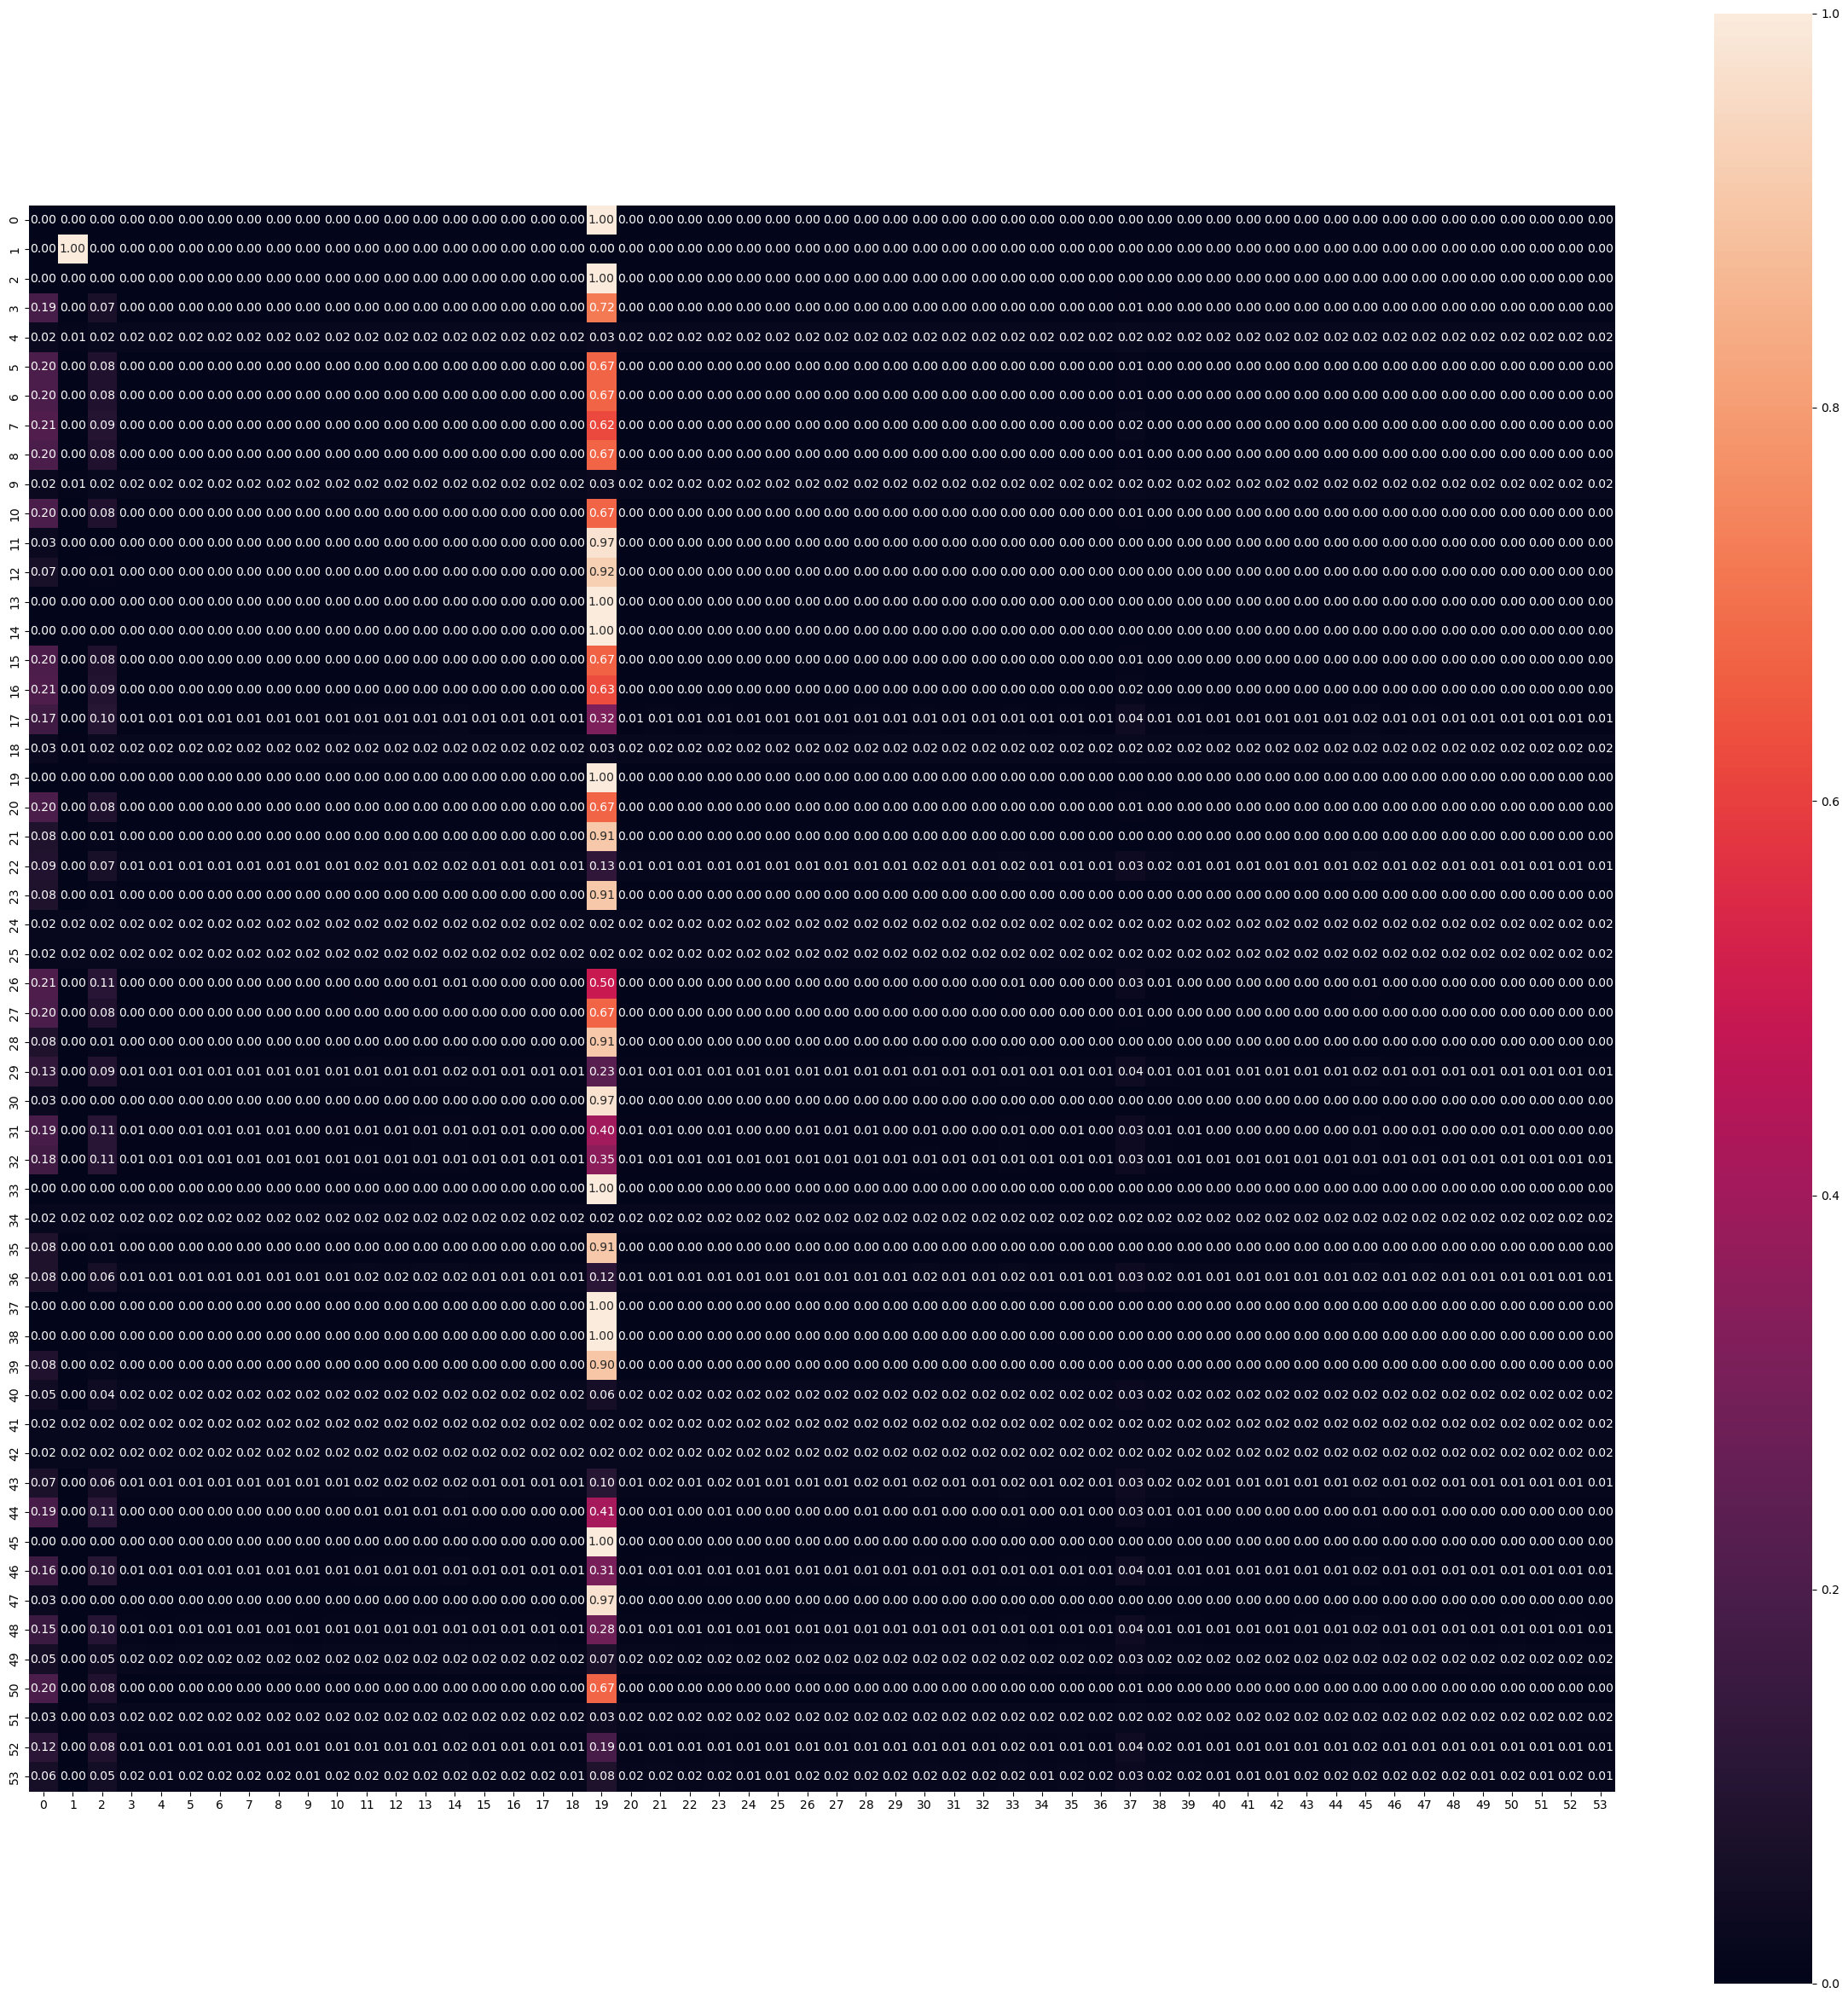

In [52]:
attn = model.layers[2]



# Reshape to (batch, N, 1) to treat each feature as a token.
x = keras.layers.Reshape((N_value, 1))(inputs)



_, attention_scores = attn(train_features[0,:].reshape(1,-1,1), train_features[0,:].reshape(1,-1,1), return_attention_scores=True) # take one sample
plt.figure(figsize=(30,30))
sb.heatmap(attention_scores[0, 0, :, :], annot=True, cbar=True,square=True, fmt='.2f')
plt.show()


In [44]:
attention_scores[0,0,:,:].numpy().sum(axis=1)

array([1.        , 1.        , 1.        , 0.9999999 , 1.0000001 ,
       1.        , 1.        , 1.0000001 , 0.9999999 , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.0000001 , 0.9999999 , 0.99999994, 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 1.0000001 , 1.        , 0.99999994, 1.0000001 ,
       1.        , 1.        , 0.99999994, 0.99999994], dtype=float32)

In [46]:
maxidx = np.argmax(attention_scores[0,0,:,:].numpy().sum(axis=0))
maxidx
to_include[maxidx]


'mi_gaussian~assortativity~binary'